# Target :
# a.) Reduce number of parameters to less than 8k and achieve 99.4 plus test accuracy in 15 epochs

# Results :

# a.) Paramteres : 7.9k
# b.) Best train accuracy : 99.14
# c.) Best test accuracy :   99.53 (last 6 epochs are 99.4 above)

# Analysis : 
# a.) Number of network parameters reduced by decresing number of channels in CNN pipeline
# b.) Model was underfitting, hence dropout layers removed from all layers
# c.) gamma of LR scheduler has been experimented with to achieve 99.4 above

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                     #transforms.Resize((28, 28)),
                                     #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                     transforms.RandomRotation((-7.0, 7.0)),
                                     #transforms.RandomGrayscale(p=0.01),        
                                     #transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))
                                       # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=16, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
import torch.nn.functional as F
dropout_value = 0.01

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=11, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(11),
            #nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=11, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),

        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=13, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(13),
            #nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(13),
            #nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(13),
            #nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(13),
            #nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
        
        #self.pool2 = nn.MaxPool2d(6, 6) # output_size = 12


        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        #self.dropout = nn.Dropout(dropout_value)
        
        self.fc = nn.Sequential(
            nn.Linear(13, 10,bias=False),
            #nn.BatchNorm1d(10),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)   
        #x = self.pool2(x)
        
        #x = self.convblock8(x)
        #x = x.view(-1, 10)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 11, 26, 26]              99
              ReLU-2           [-1, 11, 26, 26]               0
       BatchNorm2d-3           [-1, 11, 26, 26]              22
            Conv2d-4           [-1, 16, 24, 24]           1,584
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 10, 24, 24]             160
       BatchNorm2d-8           [-1, 10, 24, 24]              20
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 13, 10, 10]           1,170
             ReLU-11           [-1, 13, 10, 10]               0
      BatchNorm2d-12           [-1, 13, 10, 10]              26
           Conv2d-13             [-1, 13, 8, 8]           1,521
             ReLU-14             [

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.0001)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.14774709939956665 Batch_id=937 Accuracy=94.90: 100%|████████████████████████████████████████████████████████████| 938/938 [00:16<00:00, 56.29it/s]



Test set: Average loss: 0.0577, Accuracy: 9857/10000 (98.57%)

EPOCH: 1


Loss=0.18898053467273712 Batch_id=937 Accuracy=97.97: 100%|████████████████████████████████████████████████████████████| 938/938 [00:16<00:00, 56.73it/s]



Test set: Average loss: 0.0427, Accuracy: 9895/10000 (98.95%)

EPOCH: 2


Loss=0.2289648950099945 Batch_id=937 Accuracy=98.28: 100%|█████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 54.66it/s]



Test set: Average loss: 0.0328, Accuracy: 9924/10000 (99.24%)

EPOCH: 3


Loss=0.06007099151611328 Batch_id=937 Accuracy=98.50: 100%|████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 49.49it/s]



Test set: Average loss: 0.0268, Accuracy: 9932/10000 (99.32%)

EPOCH: 4


Loss=0.15450215339660645 Batch_id=937 Accuracy=98.64: 100%|████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 53.68it/s]



Test set: Average loss: 0.0315, Accuracy: 9918/10000 (99.18%)

EPOCH: 5


Loss=0.02037954330444336 Batch_id=937 Accuracy=98.72: 100%|████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 81.92it/s]



Test set: Average loss: 0.0250, Accuracy: 9938/10000 (99.38%)

EPOCH: 6


Loss=0.18003688752651215 Batch_id=937 Accuracy=98.74: 100%|████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 71.09it/s]



Test set: Average loss: 0.0225, Accuracy: 9940/10000 (99.40%)

EPOCH: 7


Loss=0.006410561501979828 Batch_id=937 Accuracy=98.92: 100%|███████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 76.36it/s]



Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)

EPOCH: 8


Loss=0.03275658190250397 Batch_id=937 Accuracy=98.87: 100%|████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 66.88it/s]



Test set: Average loss: 0.0247, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.029766350984573364 Batch_id=937 Accuracy=98.95: 100%|███████████████████████████████████████████████████████████| 938/938 [00:16<00:00, 56.87it/s]



Test set: Average loss: 0.0212, Accuracy: 9943/10000 (99.43%)

EPOCH: 10


Loss=0.01713288575410843 Batch_id=937 Accuracy=99.03: 100%|████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 54.71it/s]



Test set: Average loss: 0.0186, Accuracy: 9953/10000 (99.53%)

EPOCH: 11


Loss=0.041618794202804565 Batch_id=937 Accuracy=99.05: 100%|███████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 51.30it/s]



Test set: Average loss: 0.0181, Accuracy: 9949/10000 (99.49%)

EPOCH: 12


Loss=0.06999717652797699 Batch_id=937 Accuracy=99.09: 100%|████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 71.49it/s]



Test set: Average loss: 0.0212, Accuracy: 9947/10000 (99.47%)

EPOCH: 13


Loss=0.013805992901325226 Batch_id=937 Accuracy=99.14: 100%|███████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 71.81it/s]



Test set: Average loss: 0.0182, Accuracy: 9949/10000 (99.49%)

EPOCH: 14


Loss=0.15491002798080444 Batch_id=937 Accuracy=99.14: 100%|████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 72.56it/s]



Test set: Average loss: 0.0186, Accuracy: 9951/10000 (99.51%)



Text(0.5, 1.0, 'Test Accuracy')

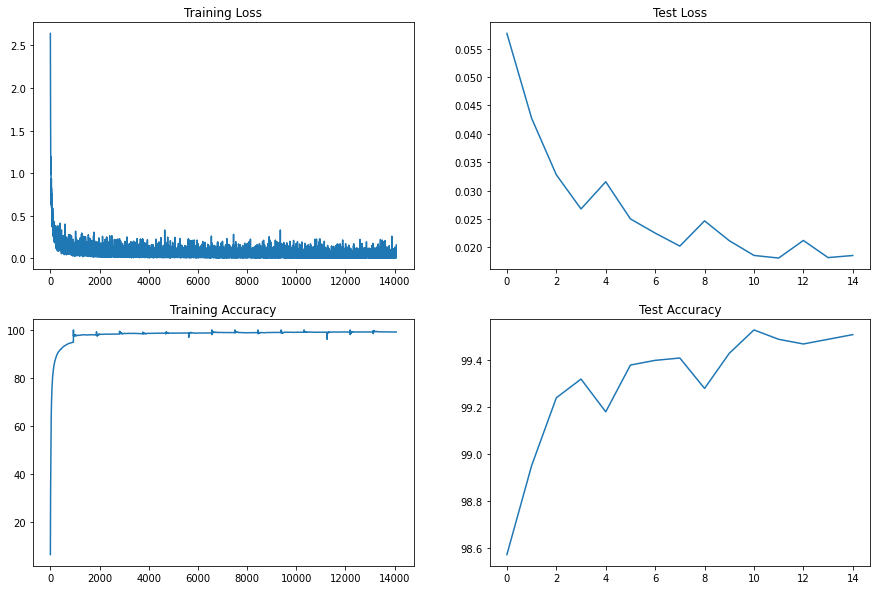

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

train_losses_cpu = []
for loss in train_losses:
    train_losses_cpu.append(loss.cpu().data.numpy())    

    
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_cpu)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")